## Librerias a utilizar

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report





## Paso 1. Planteamiento del problema y recopilación de datos

Estoy analizando un conjunto de datos proveniente originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El objetivo es predecir en base a medidas diagnósticas si un paciente tiene o no diabetes. Comprende las siguientes variables:

- Pregnancies. Número de embarazos del paciente (numérico)
- Glucose. Concentración de glucosa en plasma a las 2 horas de un test de tolerancia oral a la glucosa (numérico)
- BloodPressure. Presión arterial diastólica (medida en mm Hg) (numérico)
- SkinThickness. Grosor del pliegue cutáneo del tríceps (medida en mm) (numérico)
- Insulin. Insulina sérica de 2 horas (medida en mu U/ml) (numérico)
- BMI. Índice de masa corporal (numérico)
- DiabetesPedigreeFunction. Función de pedigrí de diabetes (numérico)
- Age. Edad del paciente (numérico)
- Outcome. Variable de clase (0 o 1), siendo 0 negativo en diabetes y 1, positivo (numérico). Variable clase a predecir.

Para efectos del estudio voy a excluir las variables BloodPressure y SkinThickness, previa evaluacion tienen un factor de correlación bajo en relacion a la clase a predecir. El resto de las variables no presentan coeficientes de correlación entre si por encima de 0,7 para evitar el fenomeno de multicolinearidad.


In [73]:
data_d=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
data_d.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [74]:
var=['Pregnancies','Glucose','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']
data_f=data_d[var]
data_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   Insulin                   768 non-null    int64  
 3   BMI                       768 non-null    float64
 4   DiabetesPedigreeFunction  768 non-null    float64
 5   Age                       768 non-null    int64  
 6   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 42.1 KB


## Paso 2. Exploracion y limpieza de datos

- El Dataset esta conformado por 768 valores, 7 variables, incluyendo la clase a predecir (Outcome), las predictoras estan conformadas por: Pregnancies, Glucose, Insulin, BMI, DiabetesPedigreeFunction y Age.

- No existen valores nulos ni duplicados. Solo queda por revisar la presencia de valores atipicos.

- La distribucion de los tipos de variables es la siguiente:

    - Pregnancies               <span style="color: magenta;">**int64**</span>
    - Glucose                   <span style="color: magenta;">**int64**</span>
    - Insulin                   <span style="color: magenta;">**int64**</span>
    - BMI                       <span style="color: magenta;">**float64**</span>
    - DiabetesPedigreeFunction  <span style="color: magenta;">**float64**</span>
    - Age                       <span style="color: magenta;">**int64**</span>
    - Outcome                   <span style="color: magenta;">**int64**</span>

In [75]:
data_f.isnull().sum()

Pregnancies                 0
Glucose                     0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [76]:
data_f.duplicated().sum()

0

In [77]:
data_f.columns

Index(['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction',
       'Age', 'Outcome'],
      dtype='object')

## Paso 3. Análisis de variables univariante

### Análisis sobre variables numericas

A continuacion se muestran histogramas para las variables: Pregnancies, Glucose, Insulin, BMI, DiabetesPedigreeFunction,
Age, Outcome.

el analisis de los histogramas por cada variable arroja la siguiente informacion:

- **Pregnancies.** 75% Valores son <= a 6, mediana = 3, media = 3.8, valor max 17. Sesgo positvo.

- **Glucose.** 75% Valores son <= a 140.25, mediana = 117.0, media = 120.9, valor max 199.

- **Insulin.** 75% Valores son <= a 127.25, mediana = 30.5, media = 79.8, valor max 846. Sesgo +.            

- **BMI.** 75% Valores son <= a 36.6, mediana = 32.0, media = 32.0 %, moda=32. valor max 67.1. Distribucion Normal. Mediana=Media=Moda.                         

- **DiabetesPedigreeFunction.** 75% Valores son <= a 0.63, mediana = 0.37, media = 0.47, valor max 2.42. Sesgo +.

- **Age.** 75% Valores son <= a 41, mediana = 29, media = 33, valor max 81. Sesgo +.   

- **Outcome.** 35% de los Valores son = a 1 y el 65% son iguales a 0. La variable clase esta **desbalanceada** se va a proceder con la eliminacion de registros para evitar sesgos en el modelo final.    

In [78]:
data_f.Outcome.describe()

count    768.000000
mean       0.348958
std        0.476951
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Outcome, dtype: float64

### Graficos Variables (solo numéricas)

In [79]:
data_f.loc[data_f.Outcome==1]

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,0,33.6,0.627,50,1
2,8,183,0,23.3,0.672,32,1
4,0,137,168,43.1,2.288,33,1
6,3,78,88,31.0,0.248,26,1
8,2,197,543,30.5,0.158,53,1
...,...,...,...,...,...,...,...
755,1,128,110,36.5,1.057,37,1
757,0,123,0,36.3,0.258,52,1
759,6,190,0,35.5,0.278,66,1
761,9,170,0,44.0,0.403,43,1


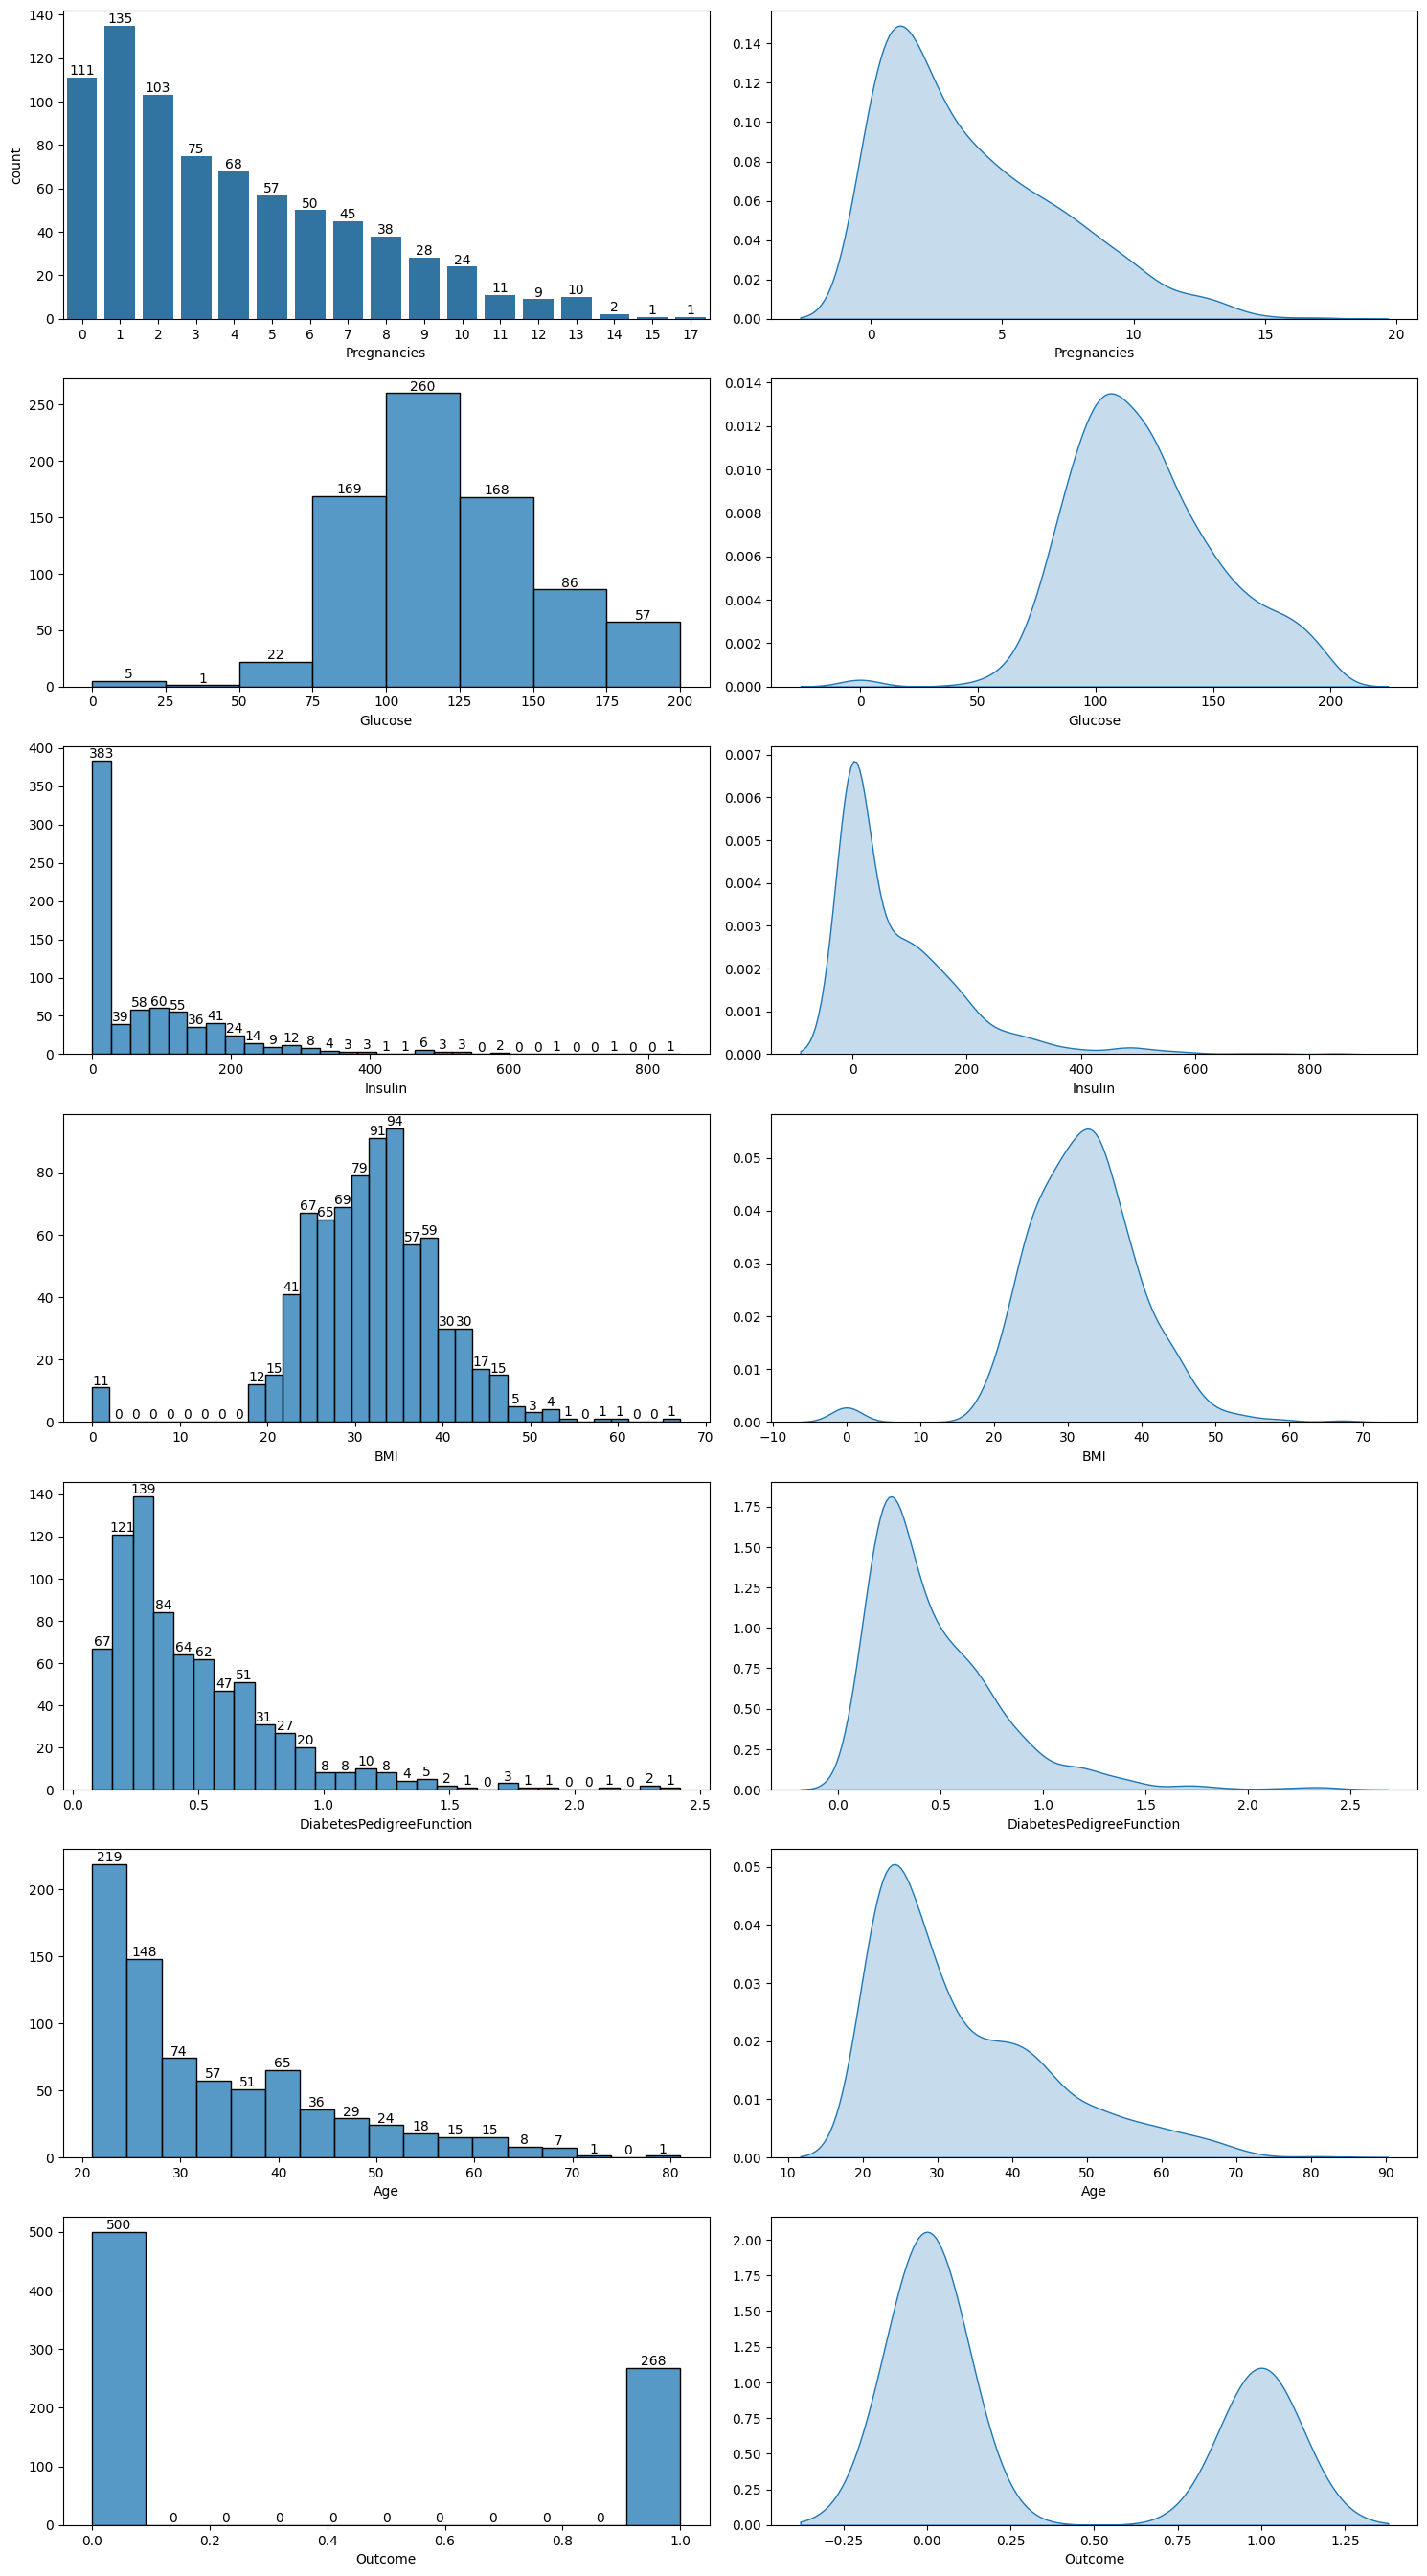

In [80]:
fig, axis = plt.subplots(7,2, figsize = (15, 27))

#sns.set_palette("Dark")
# Crear un histograma múltiple
sns.countplot(ax = axis[0,0], data = data_f, x = "Pregnancies")
axis[0,0].bar_label(axis[0,0].containers[0])
sns.kdeplot(ax = axis[0,1], data = data_f["Pregnancies"],fill=True).set(ylabel = None)

sns.histplot(ax = axis[1,0],data = data_f, x = "Glucose", bins=(0,25,50,75,100,125,150,175,200)).set(ylabel = None)
axis[1,0].bar_label(axis[1,0].containers[0])
sns.kdeplot(ax = axis[1,1], data = data_f["Glucose"],fill=True).set(ylabel = None)

sns.histplot(ax = axis[2,0], data = data_f, x = "Insulin").set(ylabel = None) 
axis[2,0].bar_label(axis[2,0].containers[0])
sns.kdeplot(ax = axis[2,1], data = data_f["Insulin"],fill=True).set(ylabel = None)

sns.histplot(ax = axis[3,0],data = data_f, x = "BMI").set(ylabel = None) 
axis[3,0].bar_label(axis[3,0].containers[0])
sns.kdeplot(ax = axis[3,1], data = data_f["BMI"],fill=True).set(ylabel = None)

sns.histplot(ax = axis[4,0], data = data_f, x = "DiabetesPedigreeFunction").set(ylabel = None)
axis[4,0].bar_label(axis[4,0].containers[0])
sns.kdeplot(ax = axis[4,1], data = data_f["DiabetesPedigreeFunction"],fill=True).set(ylabel = None)

sns.histplot(ax = axis[5,0], data = data_f, x='Age').set(ylabel = None)
axis[5,0].bar_label(axis[5,0].containers[0])
sns.kdeplot(ax = axis[5,1], data = data_f["Age"],fill=True).set(ylabel = None)

sns.histplot(ax = axis[6,0], data = data_f, x='Outcome').set(ylabel = None)
axis[6,0].bar_label(axis[6,0].containers[0])
sns.kdeplot(ax = axis[6,1], data = data_f['Outcome'],fill=True).set(ylabel = None)

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

## Paso 4. Análisis de variables multivariante

Se va a comparar la variable objetivo **'Outcome'** con las variables numericas predictoras: Pregnancies, Glucose, Insulin, BMI, DiabetesPedigreeFunction, Age. 

**Principales conclusiones:**

- En los gráficos barplot's que se realizaron de las caracteristicas versus el target Outcome, se observa como existe una correlacion en mayor o menor grado. 

- La relación observada es positiva, es decir, la presencia de la diabetis (valor 1), se observa con incrementos de cada una de las características. Los valores promedios de las caracteristicas son más altos en la clase 1 que 0.

- En orden descendente, el factor de correlación de las características con el target quedó determinado de la siguiente manera:
    - Glucosa 0.47
    - BMI 0.29
    - Age 0.24
    - Pregnancies 0.22
    - DiabetesPedigreeFunction 0.17
    - Insulin 0.13

In [81]:
data_f.columns

Index(['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction',
       'Age', 'Outcome'],
      dtype='object')

### Gráficos Variable Clase Versus Predictoras

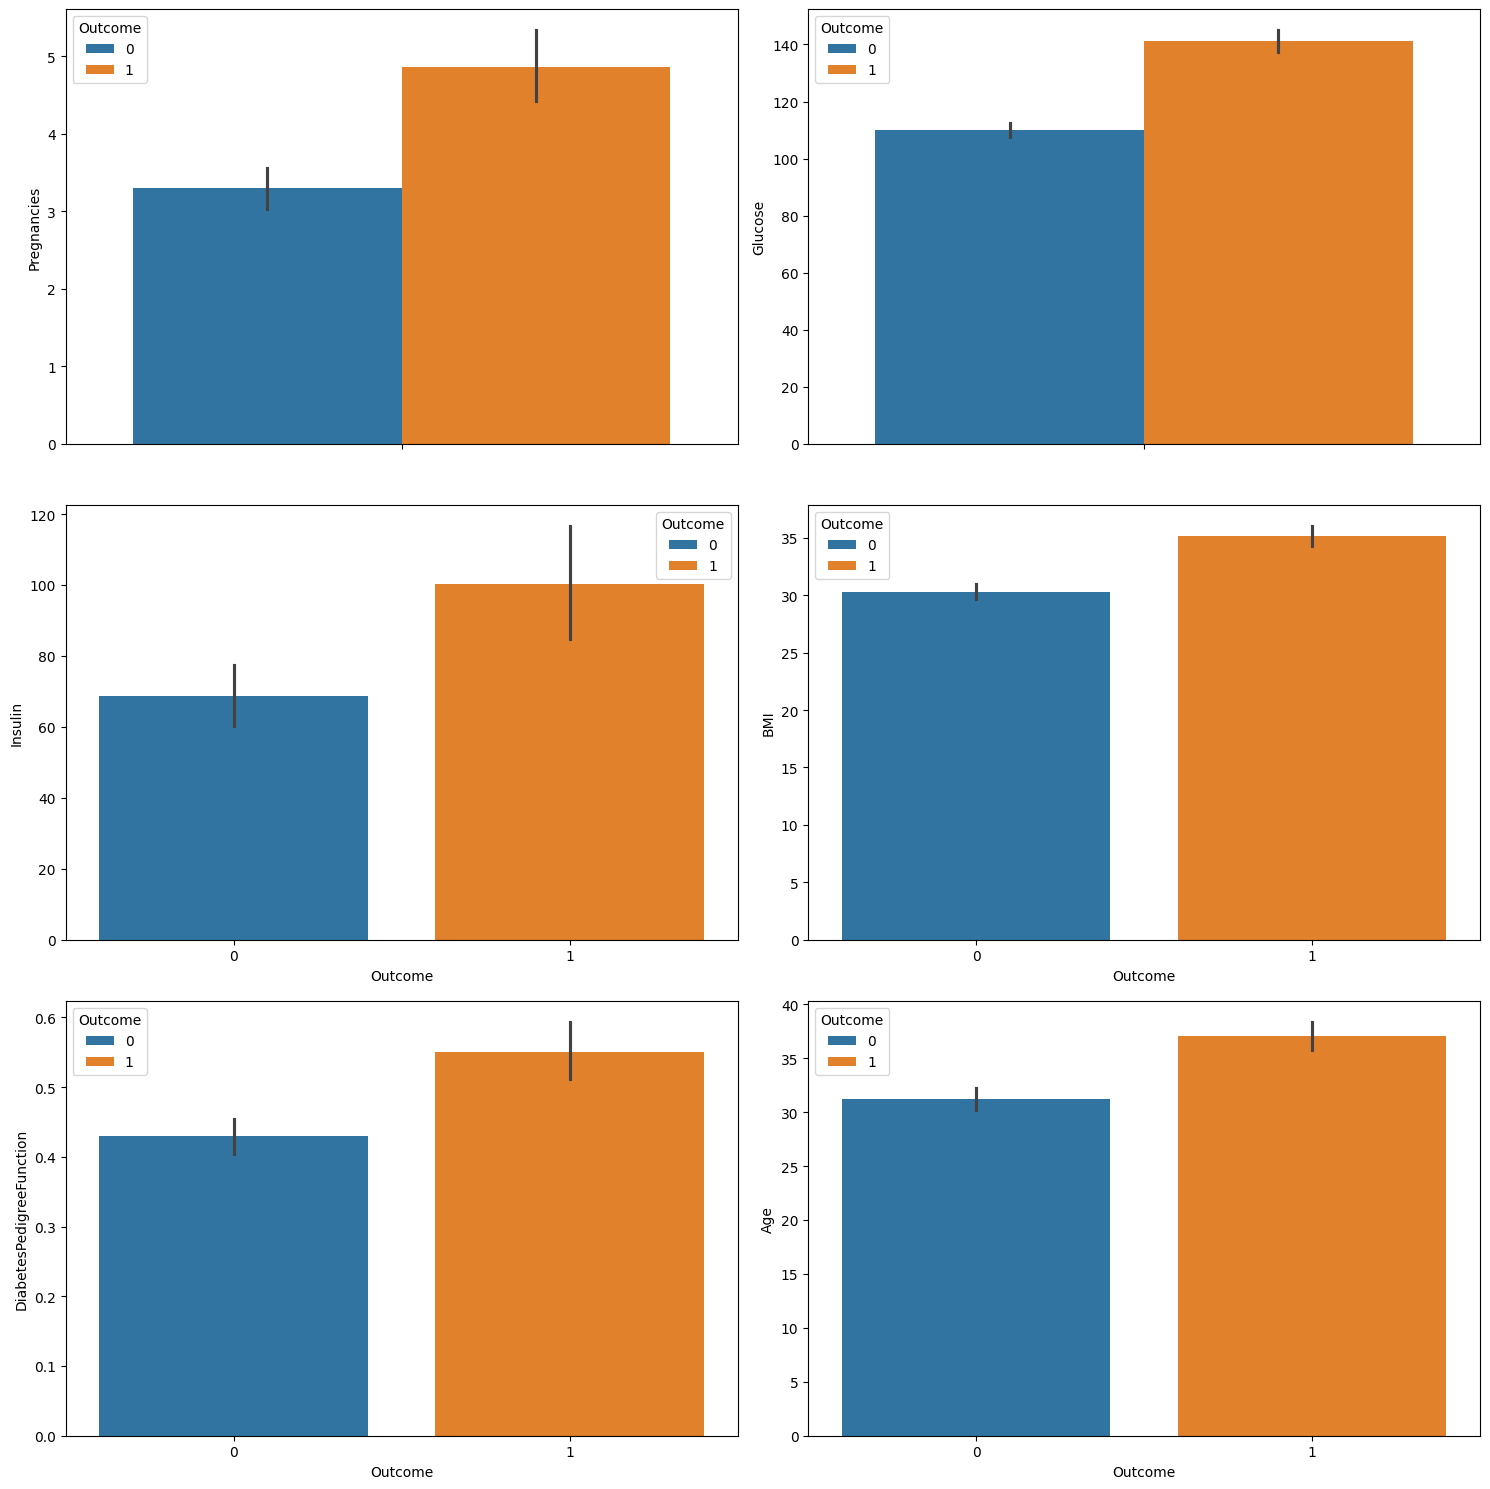

In [82]:
fig, axis = plt.subplots(3,2, figsize = (15, 15))

sns.barplot(ax = axis[0, 0], data = data_f, y="Pregnancies", hue='Outcome')
sns.barplot(ax = axis[0, 1], data = data_f, y ="Glucose", hue='Outcome')
sns.barplot(ax = axis[1, 0],data=data_f,x ='Outcome', y="Insulin", hue='Outcome')
sns.barplot(ax = axis[1,1],data=data_f,x ='Outcome', y="BMI", hue='Outcome')
sns.barplot(ax = axis[2, 0],data=data_f,x ='Outcome', y="DiabetesPedigreeFunction", hue='Outcome')
sns.barplot(ax = axis[2,1],data=data_f,x ='Outcome', y="Age", hue='Outcome')
#sns.swarmplot(ax = axis[2,1],data=data_f,x ='Outcome', y="Insulin", hue='Outcome')
#sns.jointplot(x=data_s['Active Primary Care Physicians per 100000 Population 2018 (AAMC)'], y=data_s['anycondition_prevalence'], kind="hex")

plt.tight_layout()
#fig.delaxes(axis[2,1])
#fig.delaxes(axis[2,2])

plt.show()

### Matriz de Correlación

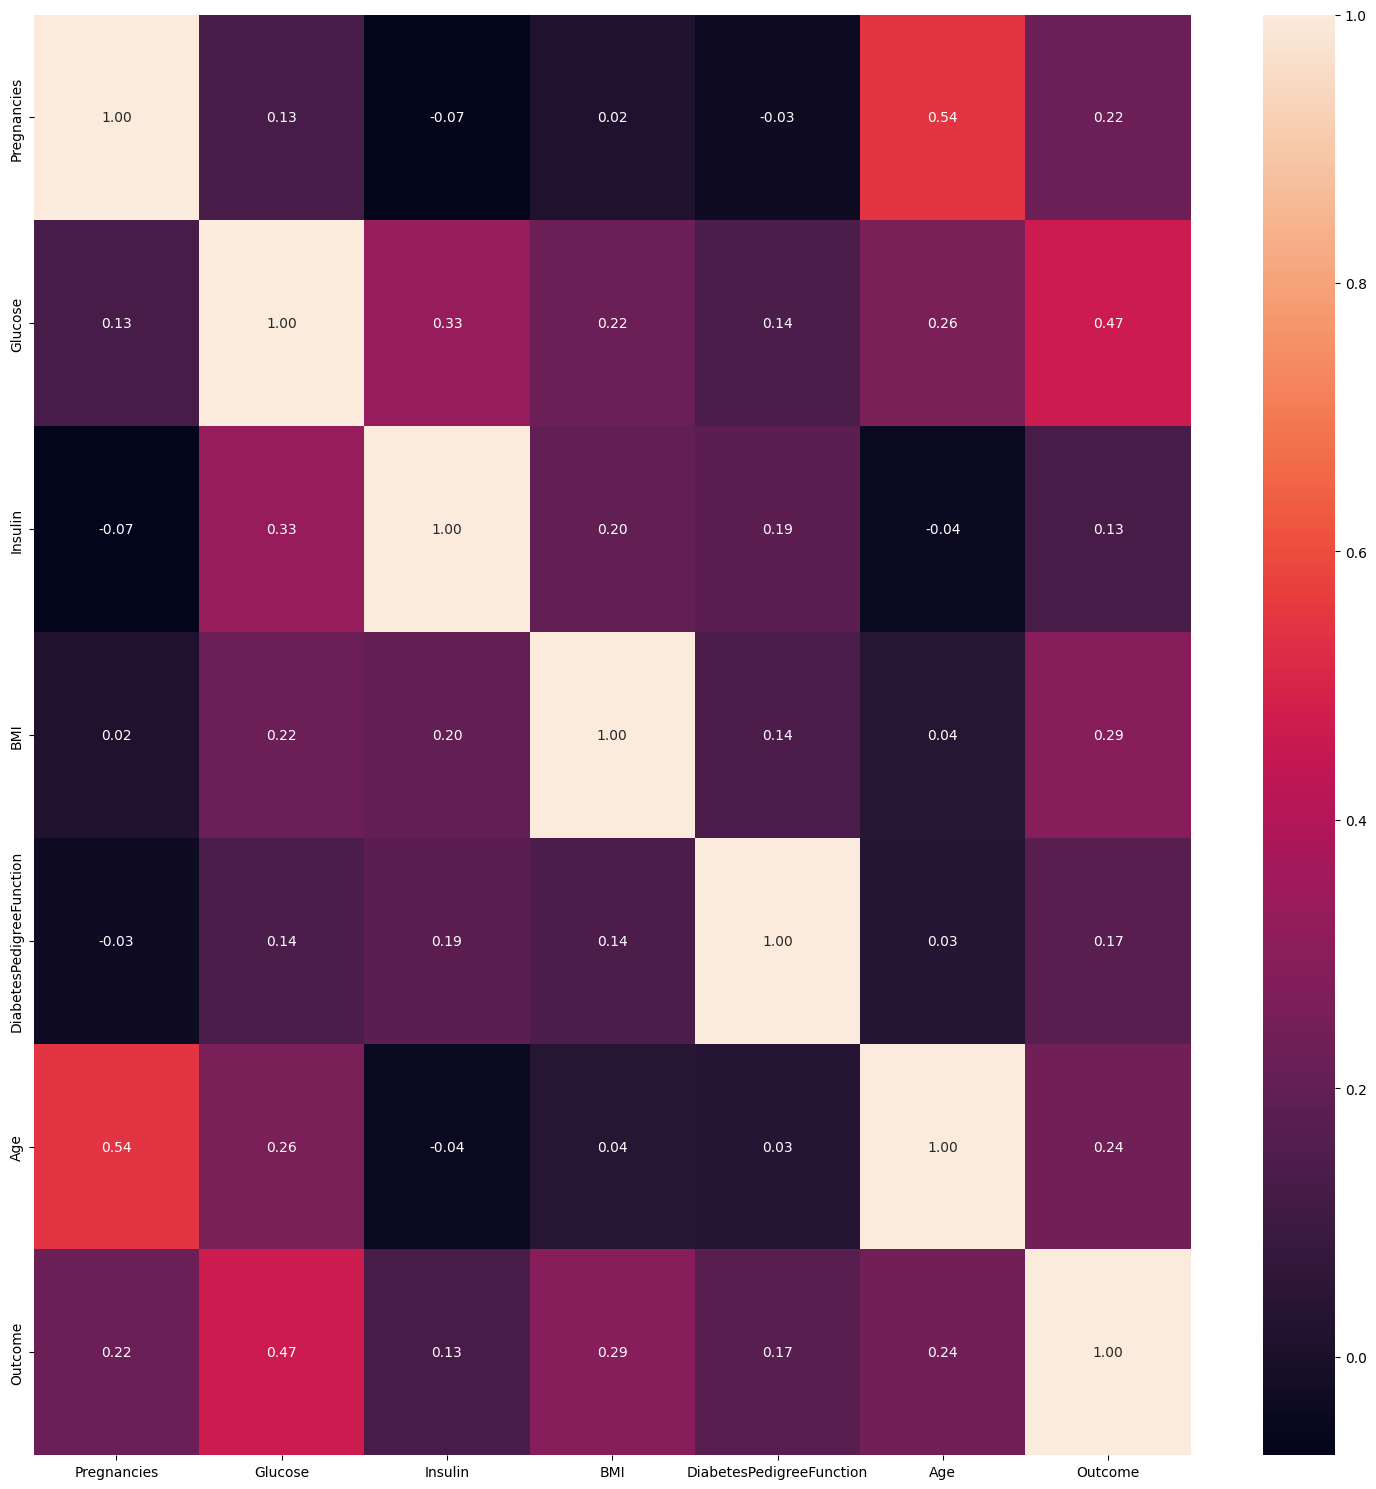

In [83]:
fig, axis = plt.subplots(figsize = (15,15))
matriz_corr=data_f.corr()
#print(matriz_corr)
sns.heatmap(matriz_corr, annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

## Paso 5. Ingenieria de Características

La primera actividad a realizar es balancear la variable objetivo, dado la poca cantidad de datos, vamos a realizar un Oversampling de la clase minoritaria, creando nuevos registros sintéticos mediante la interpolación de los registros existentes.

Posteriormente se estarán revisando valores atipicos para las variables: 

- Glucose
- BMI
- Age
- Pregnancies
- DiabetesPedigreeFunction
- Insulin
- Outcome

### Oversampling de la clase minoritaria

In [84]:
var_x=['Pregnancies','Glucose','Insulin','BMI','DiabetesPedigreeFunction','Age']
X=data_f[var_x]
y=data_f['Outcome']
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

In [85]:
X_bal.shape
y_bal

0      1
1      0
2      1
3      0
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: Outcome, Length: 1000, dtype: int64

In [86]:
data_bal=X_bal.join(y_bal)

In [87]:
data_bal.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,0,33.6,0.627,50,1
1,1,85,0,26.6,0.351,31,0
2,8,183,0,23.3,0.672,32,1
3,1,89,94,28.1,0.167,21,0
4,0,137,168,43.1,2.288,33,1


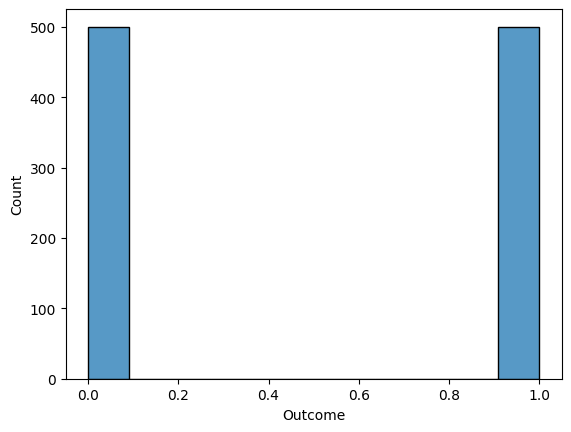

In [88]:
sns.histplot(data=data_bal, x='Outcome')
plt.show()

### Graficos BoxPlots 

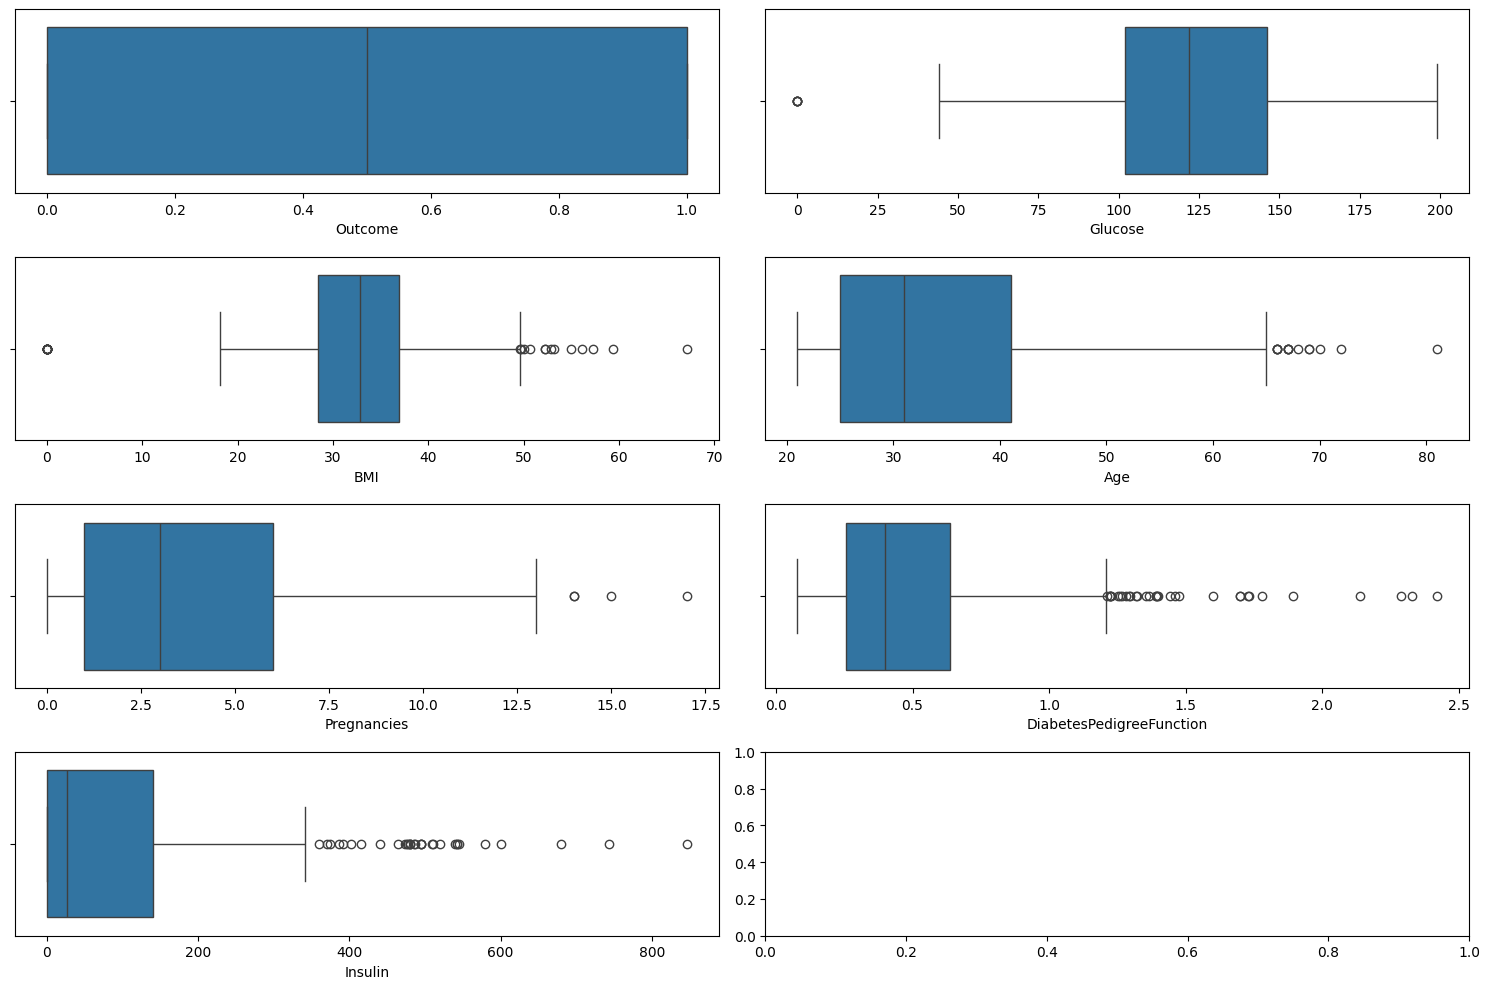

In [89]:
fig, axis = plt.subplots(4,2, figsize = (15, 10))

# Crear un histograma múltiple
sns.boxplot(ax = axis[0,0], data = data_bal, x = "Outcome")
sns.boxplot(ax = axis[0,1], data = data_bal, x = "Glucose")
sns.boxplot(ax = axis[1,0], data = data_bal, x = "BMI")
sns.boxplot(ax = axis[1,1], data = data_bal, x = "Age")
sns.boxplot(ax = axis[2,0], data = data_bal, x = "Pregnancies")
sns.boxplot(ax = axis[2,1], data = data_bal, x = "DiabetesPedigreeFunction")
sns.boxplot(ax = axis[3,0], data = data_bal, x = "Insulin")


# Ajustar el layout
plt.tight_layout()
# Mostrar el plot
plt.show()

### Valores atípicos

- **Glucose:** Se eliminan 5 registros con valores de glicemia iguales a cero.
- **BMI:** Se eliminan los valores por encima y debajo de los limites sup e inf determinados con los rangos intercuartilicos.
- **Age:** No se tiene certeza que en la muesta de esta data no hubiesen personas cercanas a los 80 años.
- **Pregnancies:** Se elimina los valores por encima de 13.5 hijos.
- **DiabetesPedigreeFunction:** El limite superior sugerido es de 1.21, pero se tomara 1.5 para eliminar valores mas hacia la cola derecha de la distribucion de los datos.
- **Insulin:** Se eliminan los valores por encima del limite sup determinado con los rangos intercuartilicos. 31 Valores



In [90]:
gluc=X_bal['Glucose'].describe()
gluc_iqr=gluc['75%']-gluc['25%']
p_lim_sup=gluc['75%']+1.5*gluc_iqr
p_lim_inf=gluc['25%']-1.5*gluc_iqr
print(f"Los límites superior e inferior para la búsqueda de outliers son {round(p_lim_sup, 2)} y {round(p_lim_inf, 2)}, con un rango intercuartílico de {round(gluc_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 212.62 y 35.62, con un rango intercuartílico de 44.25


In [91]:
bbmi=X_bal['BMI'].describe()
bbmi_iqr=bbmi['75%']-bbmi['25%']
p_lim_sup=bbmi['75%']+1.5*bbmi_iqr
p_lim_inf=bbmi['25%']-1.5*bbmi_iqr
print(f"Los límites superior e inferior para la búsqueda de outliers son {round(p_lim_sup, 2)} y {round(p_lim_inf, 2)}, con un rango intercuartílico de {round(bbmi_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 49.65 y 15.65, con un rango intercuartílico de 8.5


In [92]:
preg=X_bal['Pregnancies'].describe()
preg_iqr=preg['75%']-preg['25%']
p_lim_sup=preg['75%']+1.5*preg_iqr
p_lim_inf=preg['25%']-1.5*preg_iqr
print(f"Los límites superior e inferior para la búsqueda de outliers son {round(p_lim_sup, 2)} y {round(p_lim_inf, 2)}, con un rango intercuartílico de {round(preg_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 13.5 y -6.5, con un rango intercuartílico de 5.0


In [93]:
ins=X_bal['Insulin'].describe()
ins_iqr=ins['75%']-ins['25%']
p_lim_sup=ins['75%']+1.5*ins_iqr
p_lim_inf=ins['25%']-1.5*ins_iqr
print(f"Los límites superior e inferior para la búsqueda de outliers son {round(p_lim_sup, 2)} y {round(p_lim_inf, 2)}, con un rango intercuartílico de {round(ins_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 350.0 y -210.0, con un rango intercuartílico de 140.0


In [94]:
dpf=X_bal['DiabetesPedigreeFunction'].describe()
dpf_iqr=dpf['75%']-dpf['25%']
p_lim_sup=dpf['75%']+1.5*dpf_iqr
p_lim_inf=dpf['25%']-1.5*dpf_iqr
print(f"Los límites superior e inferior para la búsqueda de outliers son {round(p_lim_sup, 2)} y {round(p_lim_inf, 2)}, con un rango intercuartílico de {round(dpf_iqr, 2)}")



Los límites superior e inferior para la búsqueda de outliers son 1.21 y -0.32, con un rango intercuartílico de 0.38


In [95]:
X_bal.loc[X_bal['DiabetesPedigreeFunction']>1.5].count()

Pregnancies                 11
Glucose                     11
Insulin                     11
BMI                         11
DiabetesPedigreeFunction    11
Age                         11
dtype: int64

In [96]:

X_bal.drop(X_bal[X_bal["Glucose"]==0].index,inplace=True)
X_bal.drop(X_bal[X_bal["BMI"]==0].index,inplace=True)
X_bal.drop(X_bal[X_bal["BMI"]>50].index,inplace=True)
X_bal.drop(X_bal[X_bal["Pregnancies"]>13.5].index,inplace=True)
X_bal.drop(X_bal[X_bal["Insulin"]>350].index,inplace=True)
X_bal.drop(X_bal[X_bal["DiabetesPedigreeFunction"]>1.5].index,inplace=True)


### Split Data Train y Test

In [97]:
print(var_x)

['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [98]:
y=data_bal['Outcome']
X=data_bal.drop('Outcome',axis=1)[var_x]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age
29,5,117,0,34.100000,0.337000,38
535,4,132,0,32.900000,0.302000,23
695,7,142,480,30.400000,0.128000,43
557,8,110,0,27.800000,0.237000,58
836,4,122,0,32.020995,0.256373,35


<Axes: >

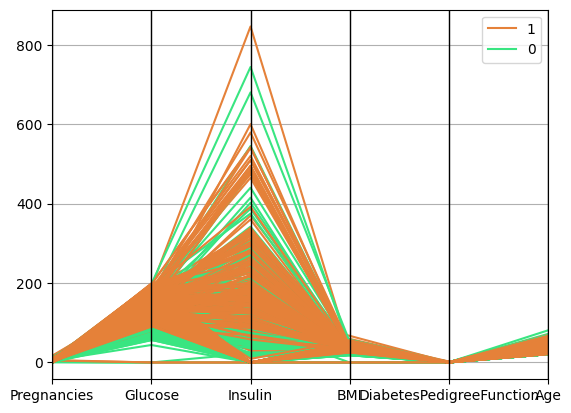

In [99]:
total_data = X
total_data["Name"] = y

pd.plotting.parallel_coordinates(total_data, "Name", color = ("#E58139", "#39E581"))

## Paso 6: Inicialización y entrenamiento del modelo

In [100]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Visualizacion del Arbol

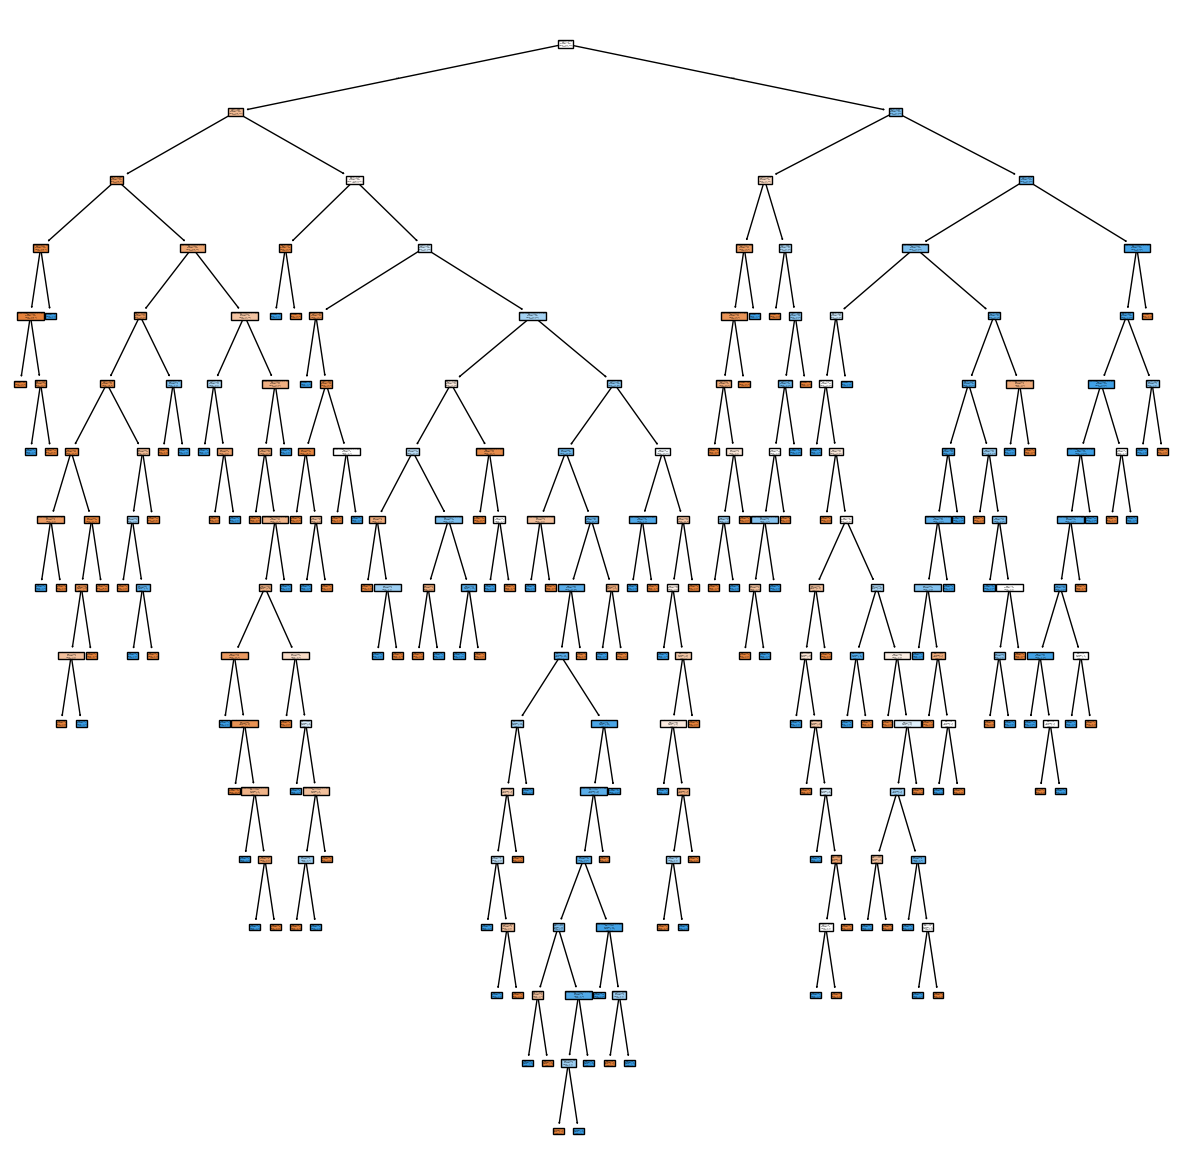

In [101]:

fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)

plt.show()

## Paso 7: Predicción del modelo

In [102]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0], dtype=int64)

In [103]:
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
predicciones_exactas = accuracy_score(y_test, y_pred, normalize=False)
print("El número de predicciones exactas es: ", predicciones_exactas) 

Accuracy Score: 0.725
El número de predicciones exactas es:  145.0


### Validacion Cruzada del Modelo

In [104]:

# Realiza la validación cruzada con 5 folds
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Imprime los resultados
print("Scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())


Scores: [0.71875 0.79375 0.78125 0.6375  0.75625]
Mean score: 0.7375
Standard deviation: 0.05618051263561058


### Optimizacion de Hiperparametros

#### RandomizedSearchCV

In [105]:

dt_space={'max_depth':[None, 50,100,500,1000], 
           'max_features':randint(1,6), 
           'criterion':['gini','entropy'], 
           'min_samples_leaf':randint(1,4), 
           'min_samples_split':np.arange(2, 10, step=2) 
          }

In [106]:
dt = DecisionTreeClassifier()
dt_random = RandomizedSearchCV(dt, dt_space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=5)
model_random = dt_random.fit(X_train, y_train)

In [107]:
print(f'Mejores Hiperparametros:: {model_random.best_params_}')
print(f'Mejor random search score es: {model_random.best_score_}')

Mejores Hiperparametros:: {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2}
Mejor random search score es: 0.7787499999999999


In [108]:
model_rd = DecisionTreeClassifier(criterion='entropy',max_depth=500,
           max_features=5, min_samples_leaf=2, min_samples_split=2,
           random_state=42)
           
model_rd.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=500, max_features=5,
                       min_samples_leaf=2, random_state=42)

In [109]:
y_pred_rd = model_rd.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_rd)}")
predicciones_exactas = accuracy_score(y_test, y_pred_rd, normalize=False)
print("El número de predicciones exactas es: ", predicciones_exactas) 

Accuracy Score: 0.745
El número de predicciones exactas es:  149.0


In [110]:
eval_ypred=pd.DataFrame(y_pred_rd)
eval_ypred.value_counts()

0
0    108
1     92
Name: count, dtype: int64

#### GridSearch

In [111]:
grid_space={'max_depth':[500,1000,1500], 
           'max_features':[5,6], 
           'criterion':['entropy','gini'], 
           'min_samples_leaf':[2,3,4,5], 
           'min_samples_split':[2,3,4] 
          }

In [112]:
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt, param_grid=grid_space, scoring='accuracy', cv=5)
model_grid = dt_grid.fit(X_train, y_train)

In [113]:
print(f'Mejores Hiperparametros:: {model_grid.best_params_}')
print(f'Mejor random search score es: {model_grid.best_score_}')

Mejores Hiperparametros:: {'criterion': 'entropy', 'max_depth': 500, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 3}
Mejor random search score es: 0.7675


In [114]:
model_gr = DecisionTreeClassifier(criterion='entropy',max_depth=500,
           max_features=5, min_samples_leaf=4, min_samples_split=2,
           random_state=42)
           
model_gr.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=500, max_features=5,
                       min_samples_leaf=4, random_state=42)

In [115]:
y_pred_gr = model_gr.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_gr)}")
predicciones_exactas = accuracy_score(y_test, y_pred_gr, normalize=False)
print("El número de predicciones exactas es: ", predicciones_exactas) 

Accuracy Score: 0.715
El número de predicciones exactas es:  143.0


Finalmente, seleccionamos el modelo encontrado con el RandomizedSearchCV con Accuracy Score: 0.745 y un número de predicciones exactas de:  149.0. 

A continuación se realizarán algunas métricas como la matriz de difusión para evaluar el rendimiento del modelo y ver si tenemos sobreajuste.

Las métricas que se pueden aplicar a este tipo de modelos son las siguientes:

- Precisión (accuracy). Mide el porcentaje de predicciones que el modelo acertó con respecto al total que hizo. Por ejemplo, cuántos correos electrónicos el modelo ha conseguido clasificar bien.
- Sensibilidad (recall). Mide la proporción de positivos reales que el modelo fue capaz de identificar. Por ejemplo, cuántos correos electrónicos que son spam reales el algoritmo ha conseguido identificar bien, quitando los que no son spam y que ha clasificado mal.
- Puntaje F1 (F1 score): Es la media de la precisión y la sensibilidad. Es útil cuando las clases están desbalanceadas.
- Área Bajo la Curva (AUC): Describe la probabilidad de que un modelo clasifique una instancia positiva elegida al azar más alta que una negativa elegida al azar.

#### Matriz de Difusión

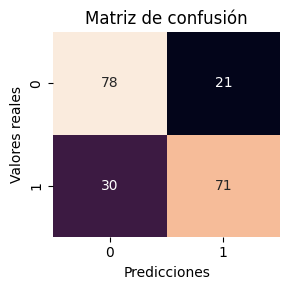

In [116]:
cm = confusion_matrix(y_test, y_pred_rd)

# Dibujaremos esta matriz para hacerla más visual
cm_df = pd.DataFrame(cm)

plt.figure(figsize = (3, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)

plt.title('Matriz de confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')

plt.tight_layout()

plt.show()

In [117]:
print(classification_report(y_test, y_pred_rd))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75        99
           1       0.77      0.70      0.74       101

    accuracy                           0.74       200
   macro avg       0.75      0.75      0.74       200
weighted avg       0.75      0.74      0.74       200



#### Conclusiones sobre las metricas: Precision y Recall

El reporte de clasificación no necesariamente me indica que tenga sobreajuste en mi modelo. Hay algunas señales que sugieren que el modelo no está sobreajustado:

Precisión y recall similares: La precisión y recall para cada clase son similares, lo que sugiere que el modelo no está sobreajustado a una clase en particular.
F1-score alto: La F1-score es una métrica que combina la precisión y recall. Un F1-score alto (en este caso, 0.74 y 0.75) sugiere que el modelo tiene un buen equilibrio entre precisión y recall.
Accuracy alto: La precisión global del modelo es de 0.74, lo que indica que el modelo clasifica correctamente el 74% de las muestras.

#### Otros parámetros para medir si existe sobreajuste.

Gap de Presicion: 0.22
Coeficiente de sobreajuste: 0.23
Ratio de Sobreajuste: 0.3
Profundidad del Modelo: 15
Num de Nodos: 231
Num de Hojas: 136


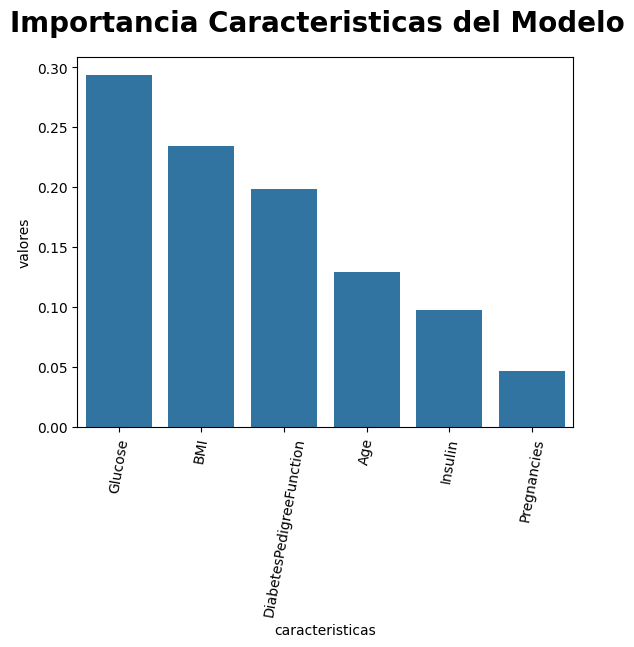

            caracteristicas   valores
1                   Glucose  0.293689
3                       BMI  0.234536
4  DiabetesPedigreeFunction  0.198439
5                       Age  0.129532
2                   Insulin  0.097363
0               Pregnancies  0.046441


In [122]:
# Predicciones en entrenamiento
y_pred_train = model_rd.predict(X_train)

# Precisión en entrenamiento
precision_train = accuracy_score(y_train, y_pred_train)

# Predicciones en evaluación
y_pred_test = model_rd.predict(X_test)

# Precisión en evaluación
precision_test = accuracy_score(y_test, y_pred_test)

# Gap de precisión
gap_precision = precision_train - precision_test
print('Gap de Presicion:',round(gap_precision,2))

#Coeficiente de sobreajuste
#Coeficiente de sobreajuste = (Precisión en entrenamiento - Precisión en evaluación) / Precisión en entrenamiento
#Un coeficiente cercano a 1 indica sobreajuste severo.
coeficiente_sobreajuste = gap_precision / precision_train
print('Coeficiente de sobreajuste:',round(coeficiente_sobreajuste,3))
# Ratio de sobreajuste
ratio_sobreajuste = (precision_train / precision_test) - 1
print('Ratio de Sobreajuste:',round(ratio_sobreajuste,2))

# Profundidad del Arbol
prof = model_rd.tree_.max_depth
print('Profundidad del Modelo:',prof)

# Numero de Nodos
num_nod = model_rd.tree_.node_count
print('Num de Nodos:', num_nod)

# Numero de Hojas
num_hojas = model.tree_.n_leaves
print('Num de Hojas:',num_hojas)

# Importancia de las características
imp_car = model_rd.feature_importances_
df = (pd.DataFrame({"caracteristicas": X_train.columns,
                        "valores": imp_car})
          .sort_values("valores", ascending=False))
sns.barplot(x = 'caracteristicas',y = 'valores',data = df, legend=False)
plt.suptitle('Importancia Caracteristicas del Modelo' , fontweight = 'black', fontsize=20)
plt.xticks(rotation=80);
plt.show()
print(df)




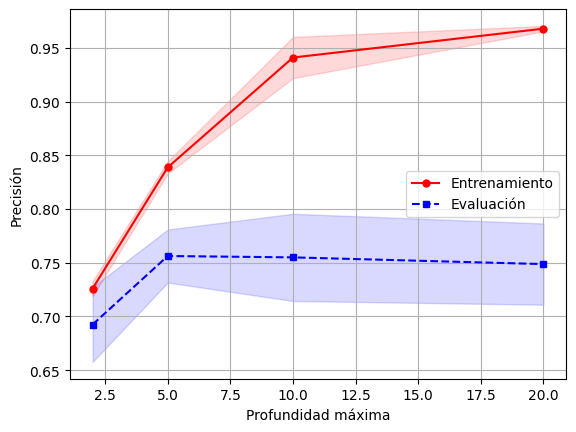

In [119]:
from sklearn.model_selection import validation_curve
# Definimos la lista de profundidades máximas para el árbol de decisión
max_deep_list = [2, 5, 10, 20]

# Calculamos la curva de aprendizaje
train_prec, eval_prec = validation_curve(estimator=model_rd, X=X_train, 
                                         y=y_train, param_name='max_depth', 
                                         param_range=max_deep_list, cv=5)

# Calculamos la media y desviación estándar de la precisión para cada profundidad
train_mean = np.mean(train_prec, axis=1)
train_std = np.std(train_prec, axis=1)
test_mean = np.mean(eval_prec, axis=1)
test_std = np.std(eval_prec, axis=1)

# Graficamos la curva de aprendizaje
plt.plot(max_deep_list, train_mean, color='r', marker='o', markersize=5, 
         label='Entrenamiento')
plt.fill_between(max_deep_list, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, color='r')
plt.plot(max_deep_list, test_mean, color='b', linestyle='--', 
         marker='s', markersize=5, label='Evaluación')
plt.fill_between(max_deep_list, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, color='b')
plt.grid()
plt.legend(loc='center right')
plt.xlabel('Profundidad máxima')
plt.ylabel('Precisión')
plt.show()

### Conclusiones

Basándome en todas las métricas que he calculado, creo que el modelo DecisionTreeClassifier puede estar presentando un ligero a moderado sobreajuste. El gap de precisión, el coeficiente de sobreajuste y el ratio de sobreajuste, sugieren que el modelo se ajusta demasiado bien a los datos de entrenamiento y no generaliza bien a nuevos datos. La profundidad del modelo y el número de nodos y hojas también sugieren una complejidad moderada. Por ultimo, tambien observo que en la importancia de las características, el modelo puede estar sobreajustando a los datos de entrenamiento en función de las características más importantes, como "Glucose" y "BMI". La interacción compleja entre estas características puede contribuir al sobreajuste.

Basándome en la curva de aprendizaje, creo que el modelo DecisionTreeClassifier presenta un sobreajuste moderado para profundidades máximas del árbol de decisión superiores a 10. La precisión del modelo en el conjunto de evaluación (test) alcanza un máximo para una profundidad máxima de alrededor de 5, lo que sugiere que este es un buen equilibrio entre la complejidad y la generalización. 
La precisión del modelo en el conjunto de evaluación (línea azul) no aumenta significativamente después de la profundiad de 5, mientras que el conjunto de entrenamiento tiene un rápido crecimiento. Esto sugiere que el modelo se ajusta demasiado bien a los datos de entrenamiento y no generaliza bien a nuevos datos.

Para abordar estos problemas, podría considerar:

- Regularizar el modelo utilizando técnicas como la reducción de la profundidad del árbol o la aplicación de un límite en el número de nodos.

- Utilizar técnicas de selección de características para reducir la dimensionalidad de los datos y evitar la sobreajuste. 

- Regularizar el modelo utilizando técnicas como la reducción de la importancia de las características más importantes o la aplicación de un límite en la interacción entre características.

- Utilizar técnicas de validación cruzada para evaluar el rendimiento del modelo en conjuntos de datos diferentes.

- Considerar la utilización de modelos más simples, como árboles de decisión con una profundidad máxima menor.

En los siguientes proyectos, se aplicaran otros modelos de clasificación, en los cuales podré evaluar bien todos estos parámetros para ver si ajusto mejor el modelo.